In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json
import community.community_louvain as community_louvain  # Explicit import to avoid conflicts
from collections import defaultdict
import random
import os
import random
from collections import defaultdict, Counter
from community import community_louvain
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


In [31]:
# Define the path to the GEXF file
file_path = 'One_Piece.gexf'  # Replace with the actual path to your file

# Read the GEXF file
try:
    G = nx.read_gexf(file_path)

    # Verify the graph is loaded by printing basic information
    num_nodes_loaded = G.number_of_nodes()
    num_edges_loaded = G.number_of_edges()

    # Output a sample of 4 nodes with their attributes
    sample_nodes_loaded = list(G.nodes(data=True))[:4]
    print("Number of Nodes:", num_nodes_loaded)
    print("Number of Edges:", num_edges_loaded)
    print("Sample Nodes with Attributes:", sample_nodes_loaded)

except FileNotFoundError:
    print(f"File not found: {file_path}")


Number of Nodes: 1083
Number of Edges: 12409
Sample Nodes with Attributes: [('A O', {'word_count': 834, 'ARC': 'Marineford Arc, Post-War Arc, Zou Arc, Wano Country Arc, Levely Arc, Egghead Arc', 'label': 'A O'}), ('Bizarre', {'word_count': 642, 'ARC': 'Marineford Arc, Post-War Arc, Zou Arc', 'label': 'Bizarre'}), ('Decalvan Brothers', {'word_count': 932, 'ARC': 'Marineford Arc, Post-War Arc, Zou Arc', 'label': 'Decalvan Brothers'}), ('Edward Newgate', {'word_count': 8416, 'ARC': 'Marineford Arc, Jaya Arc, Sabaody Archipelago Arc, Post-Enies Lobby Arc', 'label': 'Edward Newgate'})]


In [32]:
#random set
random.seed(42)
# Perform Louvain community detection
louvain_partition = community_louvain.best_partition(G)

# Group nodes by their community
communities_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    communities_louvain[community].append(node)

# Get the number of communities and sizes
num_louvain_communities = len(communities_louvain)
louvain_community_sizes = [len(nodes) for nodes in communities_louvain.values()]

# Group nodes by their community
communities_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    communities_louvain[community].append(node)

# Output the results
print("Number of Communities:", num_louvain_communities)
print("Sizes of the communities:", louvain_community_sizes)  # Display sizes of the first 10 communities

Number of Communities: 9
Sizes of the communities: [238, 102, 62, 144, 120, 118, 196, 51, 52]


In [33]:
# cleaning the text

# Function to lemmatize each word based on its part of speech
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Function to process the content text
def process_text(content, lemmatize=False):
    # Tokenize the content into individual words
    tokens = word_tokenize(content)
    
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Lemmatize the tokens if required
    if lemmatize:
        tokens = [lemmatize_word(word) for word in tokens]
    
    # Filter out rare words that appear less than 5 times
    token_counts = Counter(tokens)
    tokens = [word for word in tokens if token_counts[word] >= 5]

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

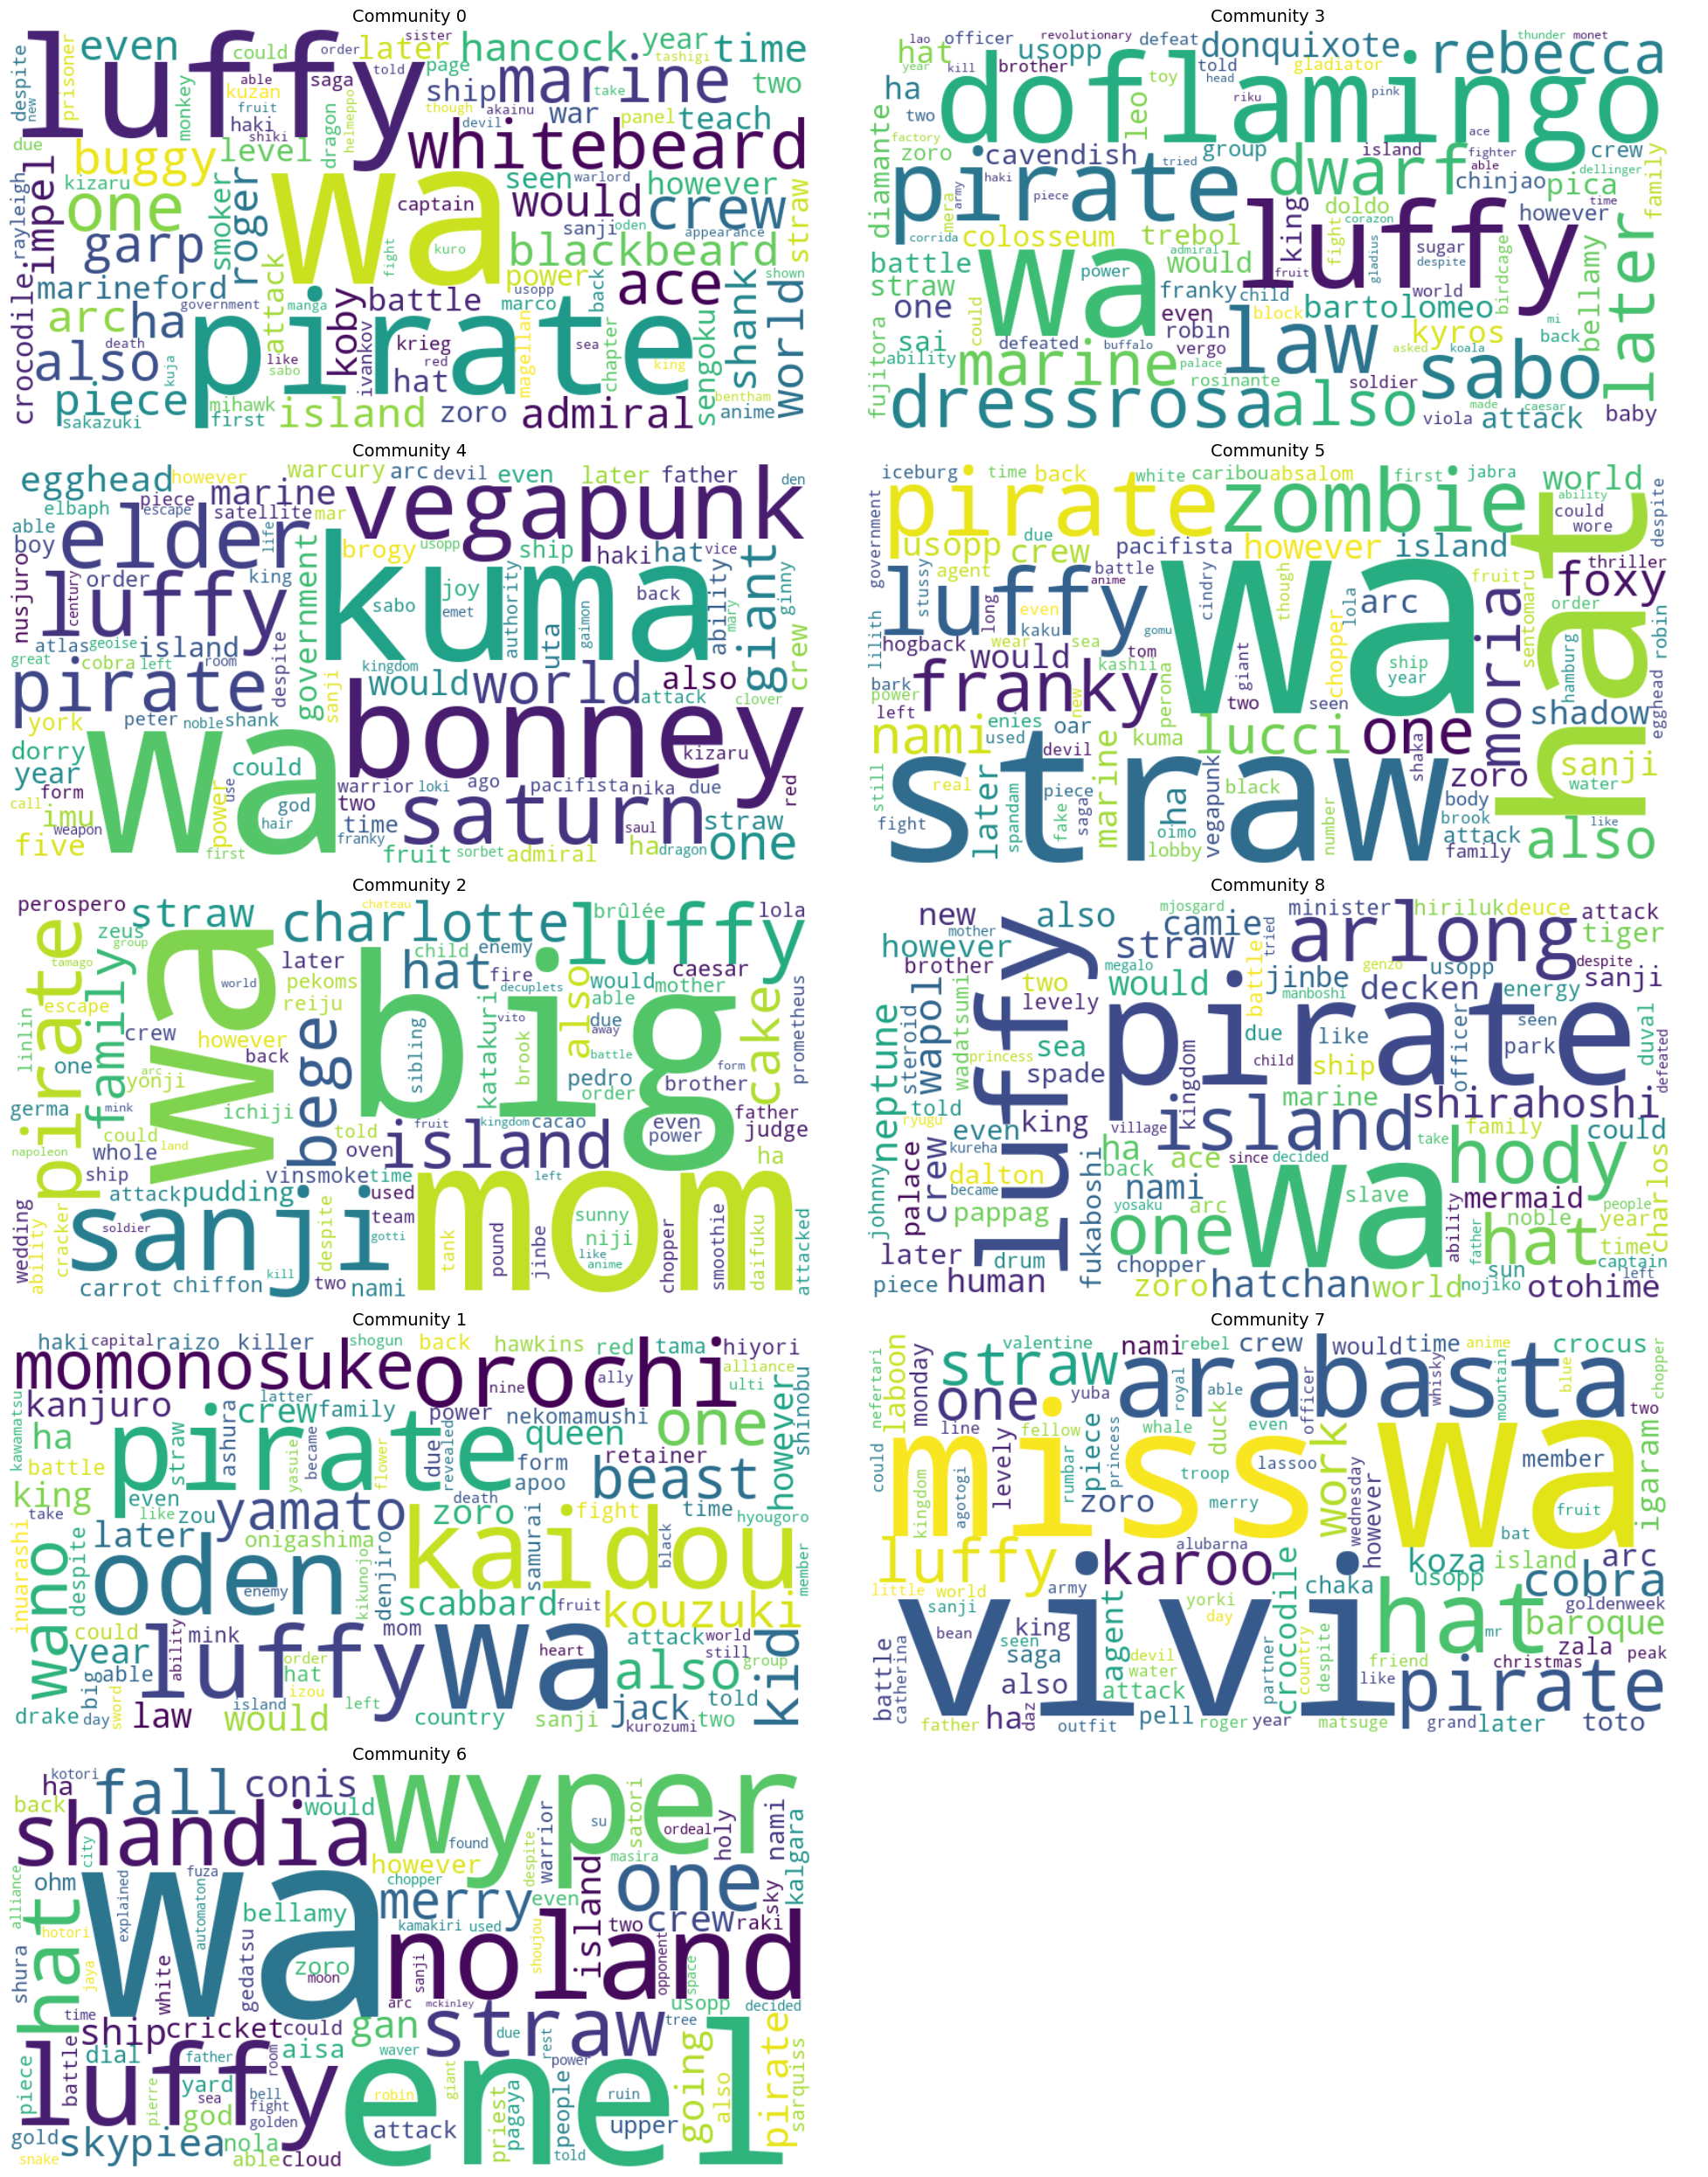

In [34]:
text_dir = "onepiece_cleaned"  # Replace with your actual directory path

# Prepare content for each community
communities_content = {}
for community, members in communities_louvain.items():
    communities_content[community] = []
    for node in members:
        filename = os.path.join(text_dir, f"{node}.txt")
        if os.path.exists(filename):
            # Read and clean the content of each file
            with open(filename, 'r', encoding='utf-8') as file:
                raw_content = file.read()
                cleaned_content = " ".join(process_text(raw_content, lemmatize=True))
                communities_content[community].append(cleaned_content)

# Prepare word clouds for up to 10 communities
fig, axes = plt.subplots(5, 2, figsize=(20, 25))  # Create a 5x2 grid for subplots
axes = axes.flatten()

# Generate word clouds
for i, (community, contents) in enumerate(communities_content.items()):
    if i >= 10:  # Limit to 10 communities
        break
    
    # Merge all text content in the community
    merged_content = " ".join(contents)
    
    # Perform TF-IDF analysis
    vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features
    X = vectorizer.fit_transform([merged_content])
    tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().flatten()))
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {community}", fontsize=14)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()